#  Milestone 1
**Ryan Schell and Tyler Brown**

Both group members contributed in different ways to ensure this was completed. Ryan did most of the cross section code and various functions throughout the notebook. Tyler did most of the doucmentation and most of code in the creation in all the maps. Overall, we both worked hard to get this done and contributed pretty equally to ensure a successful milestone 1.

In [3]:
from herbie import Herbie, FastHerbie
import pandas as pd, numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import cartopy.crs as ccrs, cartopy.feature as cfeature
import metpy.calc as mpcalc
from metpy.units import units
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section

# Gathering our Data

Through Herbie functions we are able to take data from a certain run.
We then take the 500 m heights from the run with the ss function and turn it into xarray dataset ds.

Then, we'll slice the data to only have data from the latitude and longitude we want, which in this case is all the contintial US and the surrounding area.

In [2]:
run = pd.Timestamp("2024-10-10", tz="utc").replace(tzinfo=None).floor('24h')
H = FastHerbie([run], model="ifs", product="oper", fxx=np.arange(0,246,6).tolist())
ss = r":gh:500"
ds = H.xarray(ss)

In [3]:
# Slice the data so it only gives us data for the US and surrounding areas
ds = ds.sel(latitude=slice(60,20), longitude=slice(-125,-65))
ds

<xarray.Dataset> Size: 6MB
Dimensions:              (step: 41, latitude: 161, longitude: 241)
Coordinates:
    time                 datetime64[ns] 8B 2024-10-10
  * step                 (step) timedelta64[ns] 328B 0 days 00:00:00 ... 10 d...
    isobaricInhPa        float64 8B 500.0
  * latitude             (latitude) float64 1kB 60.0 59.75 59.5 ... 20.25 20.0
  * longitude            (longitude) float64 2kB -125.0 -124.8 ... -65.25 -65.0
    valid_time           (step) datetime64[ns] 328B 2024-10-10 ... 2024-10-20
    gribfile_projection  object 8B None
Data variables:
    gh                   (step, latitude, longitude) float32 6MB 5.439e+03 .....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ifs
    product:                 oper
    description:             ECMWF Open Data - Integrated Forecast System
    search:                  :gh:500

# Initial and Verified Data

The the creation of four functions below, we can gather data that will help us create maps for the forecast and verification data, and have accurate titles with the initalization and verified time.

The first two functions, model_data and model_time allow us to get the data for our forecast hour maps. The model_data function draws data at different forecast hours, all initialized at the same time (in this case 10/10/24 at 0z). This will give us data for hour 0, 72, 144, and 240 that we can eventually plot on a map. The model_time function is simply so we can know what time the data is being called from. Then when we create the map in the title we can put the specified hour it is valid for. One thing to note is the initialization time is the same for every plot (hour 0), and then the valid time is the forecast hour we want.

The last two functions basically show the same thing, but for the verified hours. The varify_data function takes data from ds at each specified hour, which we can use in a map later. This is different from model_data as here the function is specifically taking the model run for the time specified, not just using the same model and getting a certain hour. This means that the first hour for each run is the hour we need, so it isn't a forecast, but rather accurate data or what is actually happening. The varify_time function is basically the same as the model_time function, where we can use the time provided to put on the title of the verification map. One thing to note is for this dataset the initial and valid time is the same as we are looking for the first hour in each dataset provided. 


In [4]:
# Create a variety of functions gathering the datetimes of the data and run/verify times

def model_data(time_step):
    dss = ds.isel(step=time_step)
    gh_val = dss['gh'].values
    return gh_val

# ghh gives you the predicted data from the certain hour in the future

ghh0 = model_data(0)
ghh72 = model_data(12)
ghh144 = model_data(24)
ghh240 = model_data(40)

# The time step function gives us the dates for when the original predicted heights are valid

def model_time(time_step):
    test_time = ds['valid_time'].isel(step=time_step)
    test_time = test_time['valid_time'].values
    tt_str = test_time.astype(str)
    tt_str = tt_str[:-3]
    tt_object = datetime.strptime(tt_str, "%Y-%m-%dT%H:%M:%S.%f")
    formatted_tt = tt_object.strftime("%Hz %a %b %d %Y")
    return formatted_tt

# Each hour below is used for its specified map to convey the time the data is valid 
# ghh0_time is used for all maps as the time where the data was initalized, which is 0Z on 10/10/24

ghh0_time = model_time(0)
ghh72_time = model_time(12)
ghh144_time = model_time(24)
ghh240_time = model_time(40)

# The verify data and verify time functions below allow for us to gather the time the data is verified and the data at that verification hour
# This allows for us to have a variable saying the verified time in the map title and have data to plot on top of the map

def varify_data(step_num):
    test_time = ds['valid_time'].isel(step=step_num)
    test_time = test_time['valid_time'].values
    tt_str = test_time.astype(str)
    tt_str = tt_str[:-3]
    rt = pd.Timestamp(tt_str, tz="utc").replace(tzinfo=None)
    Hf = Herbie(rt, model="ifs", product="oper", fxx=0)
    dst = Hf.xarray(ss)
    dst = dst.sel(latitude=slice(60,20), longitude=slice(-125,-65))
    return dst

def varify_time(dsv):
    test_time = dsv['valid_time']
    test_time = test_time['valid_time'].values
    tt_str = test_time.astype(str)
    tt_str = tt_str[:-3]
    tt_object = datetime.strptime(tt_str, "%Y-%m-%dT%H:%M:%S.%f")
    formatted_tt = tt_object.strftime("%Hz %a %b %d %Y")
    return formatted_tt 

Here we are just getting all the verified data formatted in a way where we can actually present it.

Then we are also finding the difference between the forecast hour and the verified hour, which will be plotted to show the accuracy of the model. For hour 0 the difference would be basically nothing, but as you move further from the inital time the difference becomes greater, meaning hour 240 should have the greatest difference.

In [5]:
# Divide the data by hour to get the model run, verification data, and difference for hour 0, 72, 144, and 240
# ghv gives the verification data at the specified time
# diff gives the difference between the model run predicted data and the verification data


dst0 = varify_data(0)
ghv0 = dst0['gh'].values
ghv0_time = varify_time(dst0)
diff_0 = ghh0 - ghv0

dst72 = varify_data(12)
ghv72 = dst72['gh'].values 
ghv72_time = varify_time(dst72)
diff_72 = ghh72 - ghv72


dst144 = varify_data(24)
ghv144 = dst144['gh'].values
ghv144_time = varify_time(dst144)
diff_144 = ghh144 - ghv144


dst240 = varify_data(-1)
ghv240 = dst240['gh'].values
ghv240_time = varify_time(dst240)
diff_240 = ghh240 - ghv240

✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


# Mapping the Data
Over the next few cells we will map the forecast heights, verified heights, and difference for every hour (0, 72, 144, 240).

In this first cell, first is the create_map function which just sets all the paramenters for all the maps we will further use, the dataproj, and lat/lon variables which just grab the data from each lat and lon we want.

The generate_interval function allows us to plot a certain amount of contours on the map with a specified spacing. Here, we want to plot every height from 532 to 600 dam at every interval of 4. This function isn't necessary, but without it the intervals would be bigger so it would be harder to see the strength and intensity of the data.

Then we created a custom colorbar, which helps us see our data in a way that makes sense. Since we are using that colorbar for our difference map, we wanted a diverging colorbar so we could see the stronger positive and negative values on the map. This wasn't too complex, but overall helped us and other viewers understand what they were seeing.

In [18]:
# Create maps at forecast hours from 10/10/24
dataproj = ccrs.PlateCarree()
lat = ds.latitude.values
lon = ds.longitude.values

def create_map(title, subplot_pos):
    ax = fig.add_subplot(subplot_pos, projection=ccrs.Miller())
    ax.set_extent([-125,-65,20,55], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    ax.set_title(title)
    return ax

# Create an interval function to be used for each hour map
def generate_interval(start, end, interval):
  return list(range(start, end + 1, interval))

numbers = generate_interval(532, 600, 4) 


# Create a custom colorbar (used google AI for help)
color_data = [
    [1.0, 0.0, 0.0], 
    [1.0, 1.0, 1.0],  
    [0.0, 0.0, 1.0]   
]

custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", color_data)


Hour 0

After getting all of our data and all of the maps properly formatted, now we can plot the data for each hour. This first cell is for hour 0, with g_plt0 being the forecasted heights at hour 0, gh_plt0 being the verified heights at hour 0, and diff_plt0 being the difference between the forecast and the verification. Since its hour 0, both plots are practically identical meaning the difference map is 0, and looks blank.

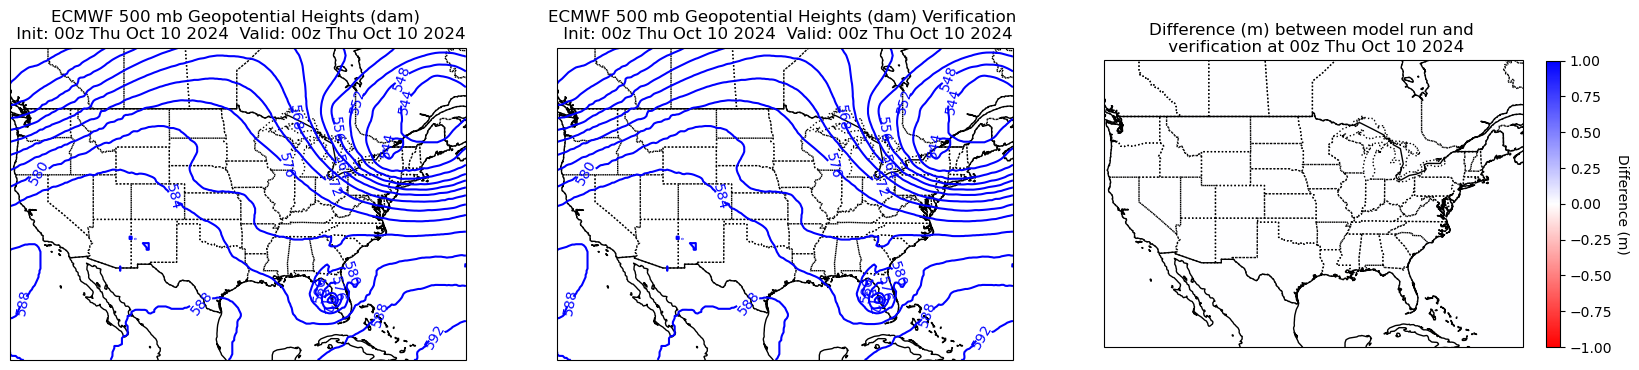

In [7]:
# Hour 0
fig = plt.figure(figsize=(20, 15))
ax1 = create_map(f'ECMWF 500 mb Geopotential Heights (dam) \n Init: {ghh0_time}  Valid: {ghh0_time}', 131)
ax2 = create_map(f'ECMWF 500 mb Geopotential Heights (dam) Verification \n Init: {ghv0_time}  Valid: {ghv0_time}', 132)
ax3 = create_map(f'Difference (m) between model run and \n verification at {ghh0_time}', 133)

numbers = generate_interval(532, 600, 4) 

# g_plt provides you a map of predicted heights at the set hour
# gh_plt provides you a map of the verified heights at the set hour
# diff_plt provides you a map with the difference between the predicted heights and verified heights

g_heights0 = ghh0 / 10
g_plt0 = ax1.contour(lon,lat, g_heights0, levels = numbers, colors = 'b', transform=dataproj)
plt.clabel(g_plt0)

geo_heights0 = ghv0 / 10
gh_plt0 = ax2.contour(lon,lat, geo_heights0, levels = numbers, colors = 'b', transform=dataproj)
plt.clabel(gh_plt0)

diff_plt0 = ax3.pcolormesh(lon ,lat, diff_0, vmin = -1, vmax = 1,cmap=custom_cmap, transform=dataproj)
im1_ratio = diff_0.shape[0]/diff_0.shape[1]
cbar_0 = plt.colorbar(diff_plt0, fraction=0.047*im1_ratio)
cbar_0.set_label('Difference (m)', rotation=270, labelpad=12)

Hour 72

Below is the maps for hour 72. As you can see, the difference is starting to increase, but still not too strong as its only 3 days in the future.

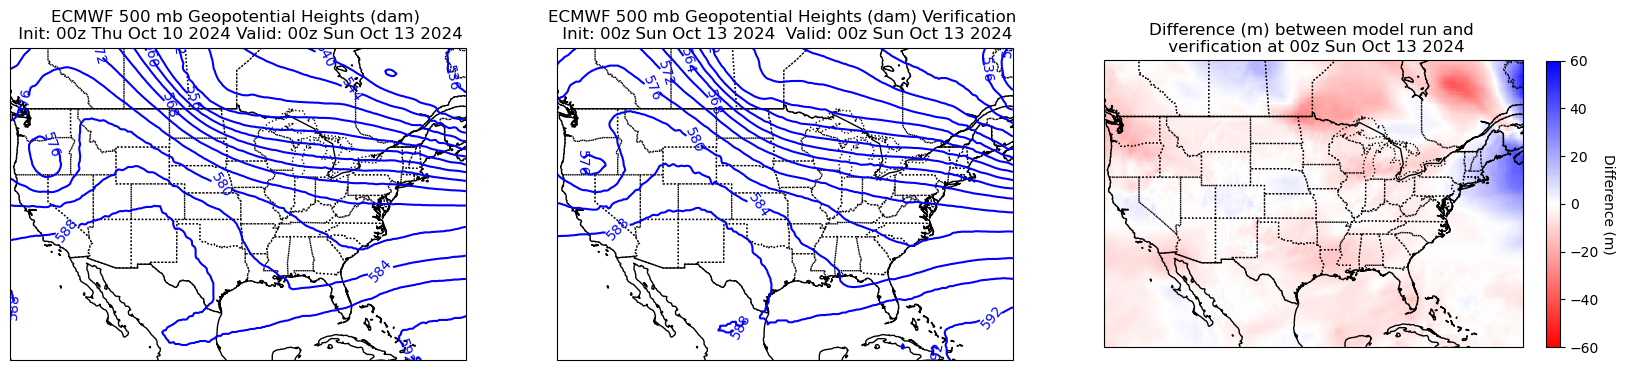

In [8]:
# Hour 72
fig = plt.figure(figsize=(20, 15))
ax1 = create_map(f'ECMWF 500 mb Geopotential Heights (dam) \n Init: {ghh0_time} Valid: {ghh72_time}', 131)
ax2 = create_map(f'ECMWF 500 mb Geopotential Heights (dam) Verification \n Init: {ghv72_time}  Valid: {ghv72_time}', 132)
ax3 = create_map(f'Difference (m) between model run and \n verification at {ghh72_time}', 133)

numbers = generate_interval(532, 600, 4) 

g_heights72 = ghh72 / 10
g_plt72 = ax1.contour(lon,lat, g_heights72, levels = numbers, colors = 'b', transform=dataproj)
plt.clabel(g_plt72)

geo_heights72 = ghv72 / 10
gh_plt72 = ax2.contour(lon,lat, geo_heights72, levels = numbers, colors = 'b', transform=dataproj)
plt.clabel(gh_plt72)

diff_plt72 = ax3.pcolormesh(lon ,lat, diff_72, vmin = -60, vmax = 60,cmap=custom_cmap, transform=dataproj)
im2_ratio = diff_72.shape[0]/diff_72.shape[1]
cbar_72 = plt.colorbar(diff_plt72, fraction=0.047*im2_ratio)
cbar_72.set_label('Difference (m)', rotation=270, labelpad=12)

Hour 144

Now we have the data for hour 144, and here we see the difference is much greater. Since there is stronger blue hues we can notice that the model tended to have a cold bias, and expected colder temps in areas that weren't so cold.

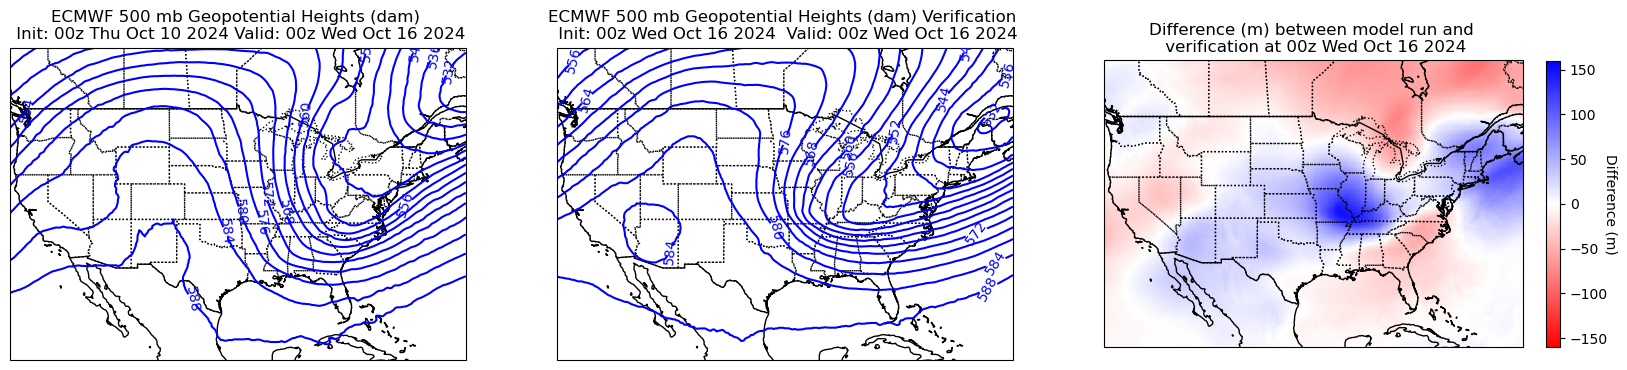

In [9]:
# Hour 144
fig = plt.figure(figsize=(20, 15))
ax1 = create_map(f'ECMWF 500 mb Geopotential Heights (dam) \n Init: {ghh0_time} Valid: {ghh144_time}', 131)
ax2 = create_map(f'ECMWF 500 mb Geopotential Heights (dam) Verification \n Init: {ghv144_time}  Valid: {ghv144_time}', 132)
ax3 = create_map(f'Difference (m) between model run and \n verification at {ghh144_time}', 133)

numbers = generate_interval(532, 600, 4) 

g_heights144 = ghh144 / 10
g_plt144 = ax1.contour(lon,lat, g_heights144, levels = numbers, colors = 'b', transform=dataproj)
plt.clabel(g_plt144)

geo_heights144 = ghv144 / 10
gh_plt144 = ax2.contour(lon,lat, geo_heights144, levels = numbers, colors = 'b', transform=dataproj)
plt.clabel(gh_plt144)

diff_plt144 = ax3.pcolormesh(lon ,lat, diff_144, vmin = -160, vmax = 160,cmap=custom_cmap, transform=dataproj)
im3_ratio = diff_144.shape[0]/diff_144.shape[1]
cbar144 = plt.colorbar(diff_plt144, fraction=0.047*im3_ratio)
cbar144.set_label('Difference (m)', rotation=270, labelpad=7)

Hour 240

Finally we have hour 240, where we see the greatest blues and reds. This indicates the struggle the models have in forecasting such long ranges. However, by looking at the maps we can see the did get somethings right, like the shortwave trough in the west.

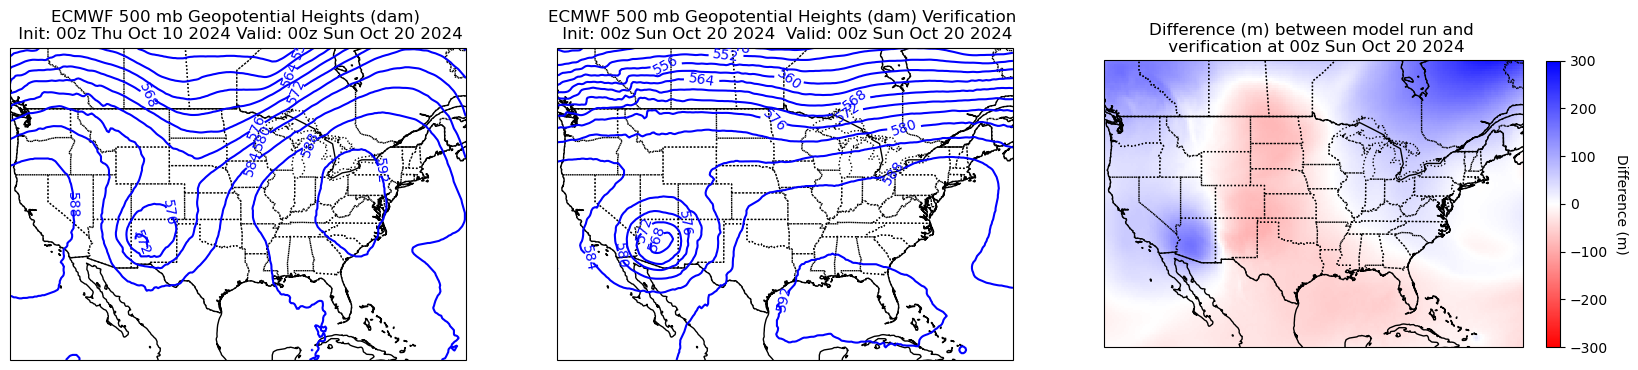

In [10]:
# Hour 240
fig = plt.figure(figsize=(20, 15))
ax1 = create_map(f'ECMWF 500 mb Geopotential Heights (dam) \n Init: {ghh0_time} Valid: {ghh240_time}', 131)
ax2 = create_map(f'ECMWF 500 mb Geopotential Heights (dam) Verification \n Init: {ghv240_time}  Valid: {ghv240_time}', 132)
ax3 = create_map(f'Difference (m) between model run and \n verification at {ghh240_time}', 133)


numbers = generate_interval(532, 600, 4) 

g_heights240 = ghh240 / 10
g_plt240 = ax1.contour(lon,lat, g_heights240, levels = numbers, colors = 'b', transform=dataproj)
plt.clabel(g_plt240)

geo_heights240 = ghv240 / 10
gh_plt240 = ax2.contour(lon,lat, geo_heights240, levels = numbers, colors = 'b', transform=dataproj)
plt.clabel(gh_plt240)

diff_plt240 = ax3.pcolormesh(lon ,lat, diff_240, vmin = -300, vmax = 300,cmap=custom_cmap, transform=dataproj)
im4_ratio = diff_240.shape[0]/diff_240.shape[1]
cbar240 = plt.colorbar(diff_plt240, fraction=0.047*im4_ratio)
cbar240.set_label('Difference (m)', rotation=270, labelpad=15)

Here we plotted the mean difference between hour 72 and 240. This plot just shows the average of the difference over hour 72, 144, and 240. It does show that overall the models were not that accurate, and struggled as a whole

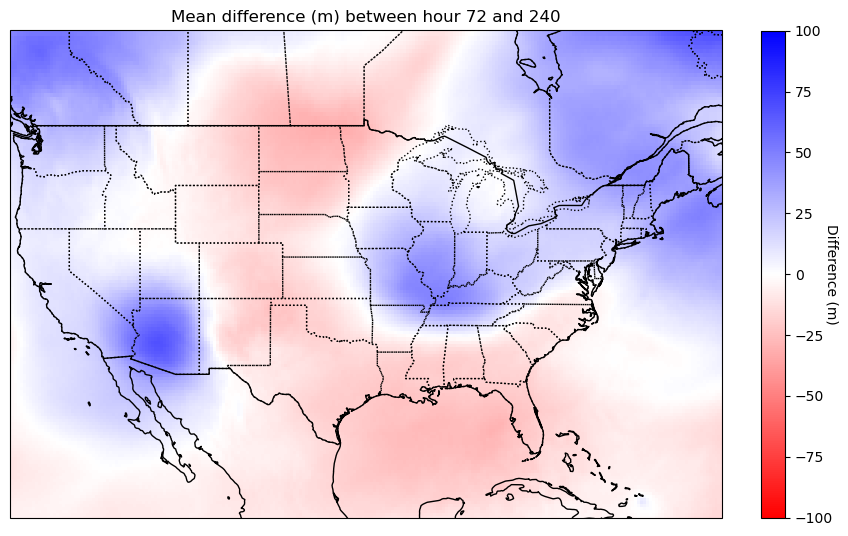

In [11]:
# Average Mean Difference between hour 72, 144, and 240

diff_avg = (diff_72 + diff_144 + diff_240) / 3
fig = plt.figure(figsize=(10, 8))
ax1 = create_map('Mean difference (m) between hour 72 and 240', 111)
diff_pltavg = ax1.pcolormesh(lon ,lat, diff_avg, vmin = -100, vmax = 100,cmap=custom_cmap, transform=dataproj)
ima_ratio = diff_avg.shape[0]/diff_avg.shape[1]
cbar_avg = plt.colorbar(diff_pltavg, fraction=0.047*ima_ratio)
cbar_avg.set_label('Difference (m)', rotation=270)

# Cross Section
The code below allows us to find cross section data of the difference. It is plotted by averaging that cross section difference data over the specified two latitude bounds, and then streched over the specified two longitude bounds to create the two plots below. These two functions below are used to create each plot, and with them being functions they allow you to change the latitude bounds to the location of your choice. Right now we have it plotted over the latitude bounds 50 to 60 degrees North and across the whole United States.

<Axes: title={'center': 'Cross Section of 50°N and 60°N Difference Between Model Run and \n Verification at 00z Sun Oct 13 2024'}, xlabel='Longitude', ylabel='Total Difference (m)'>

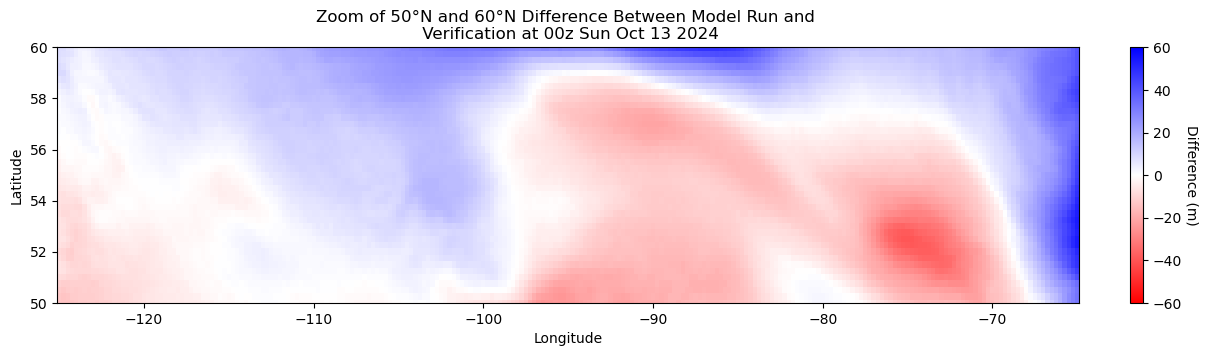

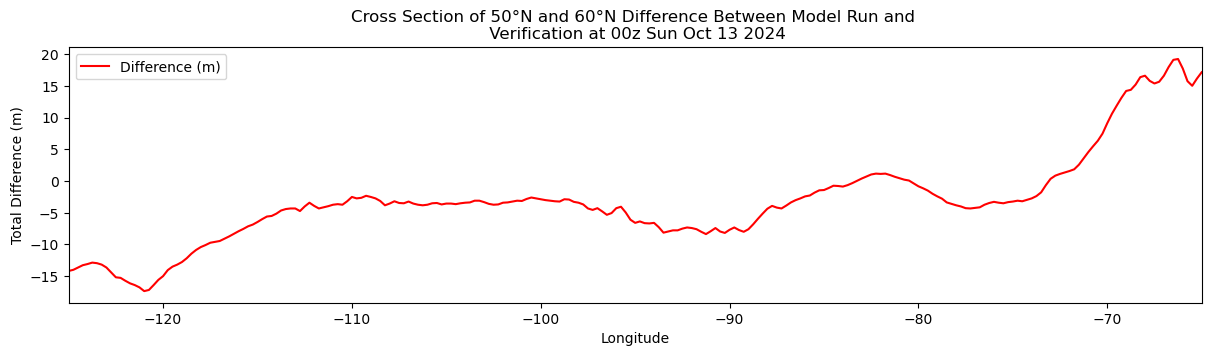

In [17]:
data_cs = [
    {'diff':diff_0,
     'vmin':-1,
     'vmax':1,
     'time':ghh0_time,
    },
    {'diff':diff_72,
     'vmin':-60,
     'vmax':60,
     'time':ghh72_time,
    },
    {'diff':diff_144,
     'vmin':-160,
     'vmax':160,
     'time':ghh144_time,
    },
    {'diff':diff_240,
     'vmin':-300,
     'vmax':300,
     'time':ghh240_time,
    },
    {'diff':diff_avg,
     'vmin':-100,
     'vmax':100,
     'time':'The Mean of All Times',
    },
]

def create_zoom_section(diff_i, cs_lat1, cs_lat2, subplot_pos):
    fig = plt.figure(figsize=(12, 6),  constrained_layout = True)
    ax = fig.add_subplot(subplot_pos)
    
    main_diff = data_cs[diff_i]
    
    zv = ax.pcolormesh(lon, lat, main_diff['diff'], vmin = main_diff['vmin'], vmax = main_diff['vmax'], cmap=custom_cmap)
    plt.ylim(cs_lat1,cs_lat2)
    cbar_zv = plt.colorbar(zv)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Zoom of {cs_lat1}°N and {cs_lat2}°N Difference Between Model Run and \n Verification at {main_diff['time']}')
    cbar_zv.set_label('Difference (m)', rotation=270, labelpad=12)
    return ax

def create_cross_section(diff_i, cs_lat1, cs_lat2, subplot_pos):
    create_zoom_section(diff_i, cs_lat1, cs_lat2, 211)
    fig = plt.figure(figsize=(12, 6),  constrained_layout = True)
    ax = fig.add_subplot(subplot_pos)

    main_diff = data_cs[diff_i]
    lat_start = cs_lat1
    lat_end = cs_lat2
    selected_diff = main_diff['diff'][lat_start:lat_end + 1, :]
    average = np.mean(selected_diff, axis=0)
    
    plt.plot(lon, average, color='r', label='Difference (m)')
    plt.title(f'Cross Section of {cs_lat1}°N and {cs_lat2}°N Difference Between Model Run and \n Verification at {main_diff['time']}')
    plt.xlim(lon[0],lon[-1])
    plt.xlabel('Longitude')
    plt.ylabel('Total Difference (m)')
    plt.legend()
    return ax

create_cross_section(1, 50, 60, 212)